# **DOA Estimation Simulation**

This notebook demonstrates with multiple sources, snapshot averaging, and robust peak detection.

## **1. Import Libraries**

In [376]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

plt.style.use('seaborn-v0_8')

## **2. Signal Model**

The received signal at an array of $M$ sensors with $K$ sources is:

$$
\mathbf{X}(t) = \mathbf{A}(\theta) \mathbf{S}(t) + \mathbf{N}(t)
$$

Where:
- $\mathbf{X}(t) \in \mathbb{C}^{M \times N}$ — received signal matrix (M sensors, N snapshots)
- $\mathbf{A}(\theta) \in \mathbb{C}^{M \times K}$ — steering matrix

$$
\mathbf{A}(\theta) =
\begin{bmatrix}
1 & 1 & \dots & 1 \\
e^{-j 2 \pi d \sin\theta_1} & e^{-j 2 \pi d \sin\theta_2} & \dots & e^{-j 2 \pi d \sin\theta_K} \\
\vdots & \vdots & \ddots & \vdots \\
e^{-j 2 \pi d (M-1) \sin\theta_1} & e^{-j 2 \pi d (M-1) \sin\theta_2} & \dots & e^{-j 2 \pi d (M-1) \sin\theta_K}
\end{bmatrix}
$$

- $\mathbf{S}(t) \in \mathbb{C}^{K \times N}$ — source signal matrix  
- $\mathbf{N}(t) \in \mathbb{C}^{M \times N}$ — additive noise

## **3. Parameters**

In [412]:
# Array and signal parameters
M = 32 # Number of sensors
d = 0.5 # Sensor spacing (wavelengths)
angles = np.array([5.0, 9.0, 30.0, 50.0, 77.0]) # Source DOAs (degrees)
num_sources = len(angles)

fs = 1000 # Sampling frequency
duration = 1 # Duration (seconds)
t = np.linspace(0, duration, int(fs*duration))  # Time vector

SNR_dB = -5 # Desired SNR at array (dB)

print(f"Number of sensors: {M}, Number of sources: {num_sources}, SNR: {SNR_dB} dB")

Number of sensors: 32, Number of sources: 5, SNR: -5 dB


## **4. Generate Source Signals (Sum of Sinusoids)**

In [413]:
def generate_source_signal(t, freqs_per_source=3, freq_range=(50, 500)):
    freqs = np.random.uniform(freq_range[0], freq_range[1], freqs_per_source)
    signal = np.sum([np.sin(2*np.pi*f*t) for f in freqs], axis=0)
    return signal

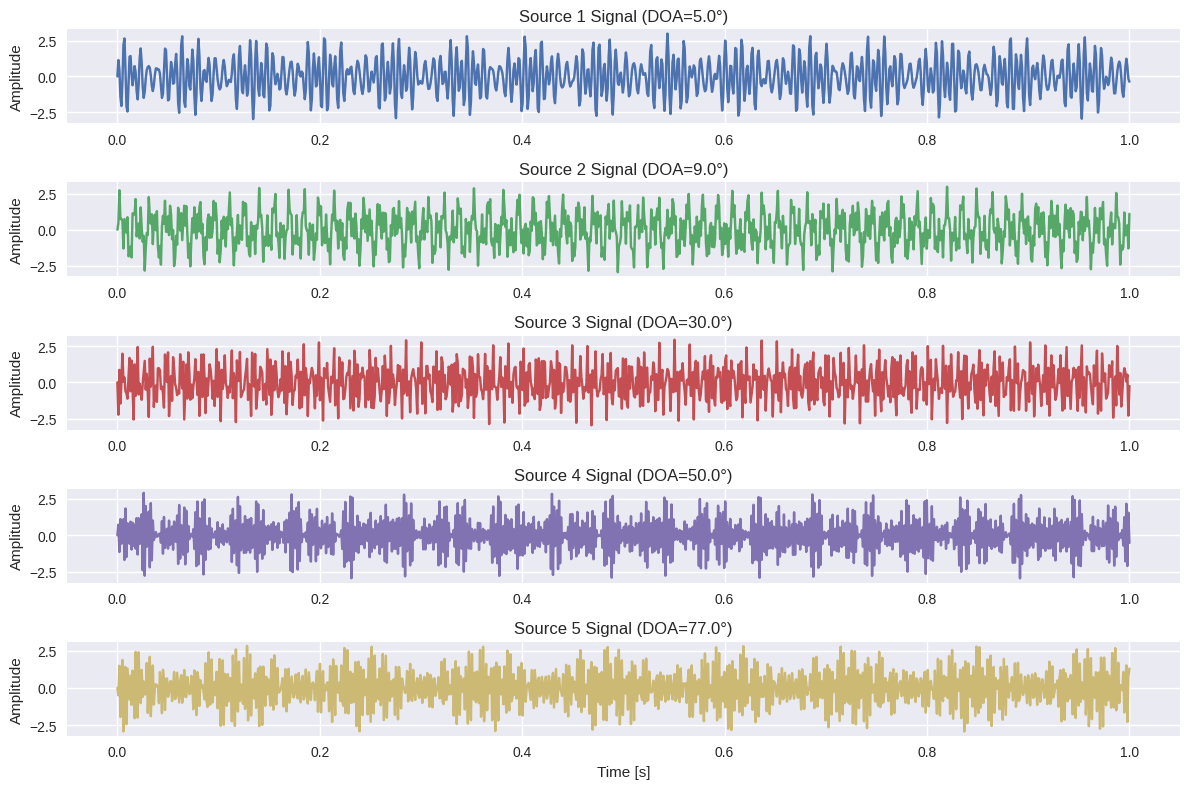

In [414]:
S = np.zeros((num_sources, len(t)))
for i in range(num_sources):
    S[i, :] = generate_source_signal(t, freqs_per_source=3, freq_range=(50, 900))

# Plot source signals
plt.figure(figsize=(12, 8))
for i in range(num_sources):
    plt.subplot(num_sources, 1, i+1)
    plt.plot(t, S[i], color=f'C{i}')
    plt.title(f"Source {i+1} Signal (DOA={angles[i]}°)")
    plt.ylabel("Amplitude")
    plt.grid(True)
plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

## **5. Steering Matrix and Received Signals**

In [415]:
# Steering matrix
A = np.zeros((M, num_sources), dtype=complex)
for i, angle in enumerate(angles):
    theta = np.deg2rad(angle)
    A[:, i] = np.exp(-1j * 2 * np.pi * d * np.arange(M) * np.sin(theta))

# Additive noise
signal_power = np.mean(np.abs(A @ S)**2)
noise_power = signal_power / 10**(SNR_dB/10)
N = np.sqrt(noise_power/2) * (np.random.randn(M, len(t)) + 1j * np.random.randn(M, len(t)))

# Received signals
X = A @ S + N

# Verify shapes
print("Steering matrix A:", A.shape)
print("Source signals S:", S.shape)
print("Noise N:", N.shape)
print("Received signals X:", X.shape)

Steering matrix A: (32, 5)
Source signals S: (5, 1000)
Noise N: (32, 1000)
Received signals X: (32, 1000)


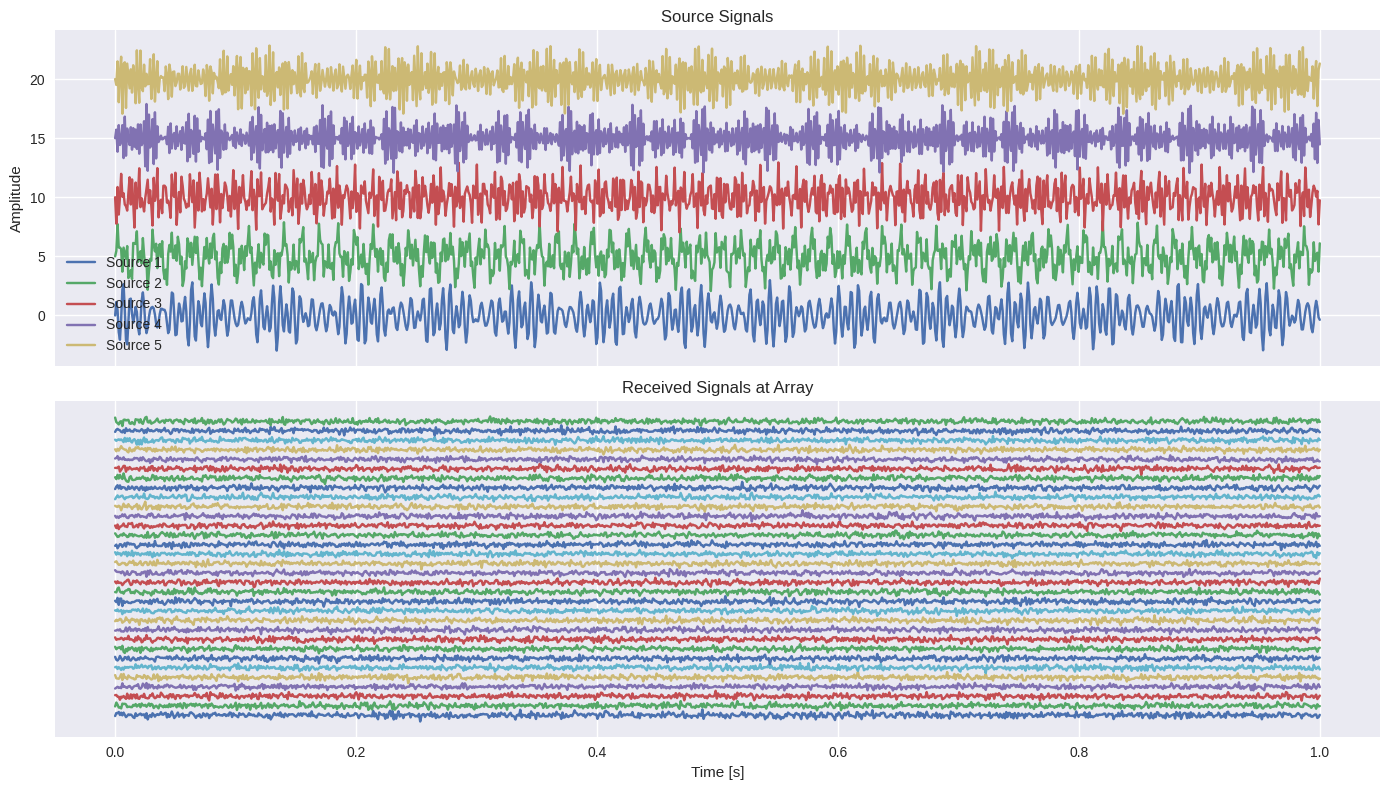

In [416]:
# Plot Received Signals
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Original sources (shifted for clarity)
for i in range(num_sources):
    axs[0].plot(t, S[i] + i*5, label=f"Source {i+1}")
axs[0].set_title("Source Signals")
axs[0].set_ylabel("Amplitude")
axs[0].legend()
axs[0].grid(True)

# Received array signals
offset = 1.5 * np.max(np.abs(X.real))
for m in range(M):
    axs[1].plot(t, X[m].real + m*offset, label=f"Sensor {m+1}")
axs[1].set_title("Received Signals at Array")
axs[1].set_xlabel("Time [s]")
axs[1].set_yticks([])
axs[1].grid(True)

plt.tight_layout()
plt.show()

## **6. Spatial Correlation Matrix**

$$
\mathbf{R}_{xx} = \frac{1}{N} \mathbf{X} \mathbf{X}^H
$$

In [417]:
Rxx = (X @ X.conj().T) / X.shape[1]
Rxx_df = pd.DataFrame(np.abs(Rxx))

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(Rxx_df)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,32.519751,3.546623,3.689050,2.832504,3.342951,4.364787,4.424566,3.474135,1.631658,5.411675,3.063277,1.171374,3.516757,3.628882,2.973842,2.440261,3.564382,2.720111,2.810423,3.166100,5.123699,3.344237,2.866716,4.652350,4.584385,3.000070,2.068610,3.299244,1.028026,7.098529,5.180109,0.916380
1,3.546623,31.148591,4.444898,2.204642,3.271195,3.595360,3.768514,3.121633,3.199743,1.903440,5.448792,3.800364,1.024527,3.045110,2.446303,1.504902,1.125304,2.641150,4.124755,3.236116,0.927563,3.745777,1.801695,3.156141,4.731720,4.589039,3.077414,2.627404,3.680999,1.157843,6.761799,5.575331
2,3.689050,4.444898,31.621505,4.192028,3.260763,3.445713,3.446174,3.754482,4.002787,3.900113,2.351200,5.217114,1.993836,1.291421,3.969885,1.861933,1.746264,2.031798,2.898724,4.808971,2.781858,2.657575,3.789651,2.092947,3.939630,4.406589,3.472106,2.888172,1.760229,3.625596,1.507400,7.544045
3,2.832504,2.204642,4.192028,29.948087,3.657852,1.753956,3.147626,2.880790,3.798282,2.927947,3.247158,1.263412,4.397528,4.319331,0.870342,3.437356,2.698591,2.273717,1.864952,3.073446,3.521276,2.236069,2.352123,3.042147,1.926433,3.033700,4.246306,3.568444,3.609567,1.746949,3.657198,2.842953
4,3.342951,3.271195,3.260763,3.657852,30.912580,4.028831,3.146948,3.414096,3.063891,4.359887,4.025402,5.295549,1.759907,5.114410,3.404698,2.127472,4.081555,2.291409,2.310404,1.607132,2.390799,3.641808,3.574813,0.120963,5.407909,2.407975,3.671383,3.777114,4.374378,3.058224,1.870599,4.834902
5,4.364787,3.595360,3.445713,1.753956,4.028831,31.260164,3.185922,2.887007,2.382678,2.165044,3.763408,3.920417,4.079310,3.435102,6.178097,3.654247,0.992830,2.768725,1.999855,2.242477,1.885734,1.317452,4.823434,3.322114,1.096952,4.344204,2.858770,2.453983,3.380112,2.423250,3.517582,1.427174
6,4.424566,3.768514,3.446174,3.147626,3.146948,3.185922,30.546440,3.028087,2.353214,2.431677,2.297621,4.234071,2.723663,4.647095,1.732765,5.273435,3.940363,0.484214,2.631988,1.384478,2.278478,1.314322,3.063941,4.072441,3.107050,1.839631,4.735530,1.764202,3.056484,3.840784,3.930166,3.738414
7,3.474135,3.121633,3.754482,2.880790,3.414096,2.887007,3.028087,30.515094,3.352497,1.625769,2.408115,2.211344,3.349337,2.474776,3.331316,1.313007,5.428498,3.674839,1.124957,3.007889,2.215351,2.650303,1.504953,2.230613,4.789117,4.005344,1.597122,4.736480,1.405128,3.303531,4.120985,3.930313
8,1.631658,3.199743,4.002787,3.798282,3.063891,2.382678,2.353214,3.352497,30.576350,3.877054,3.064823,2.854608,2.420043,3.580827,3.932705,4.708649,1.281691,4.472435,2.366867,2.081052,3.508289,1.594209,1.151788,2.168129,1.200356,3.433619,2.451245,1.965458,4.843546,2.151017,3.676252,4.870471
9,5.411675,1.903440,3.900113,2.927947,4.359887,2.165044,2.431677,1.625769,3.877054,29.840552,3.438452,1.448337,2.567647,2.305140,4.234942,4.066530,3.270932,1.961513,4.337867,2.139639,1.412704,3.172210,2.356050,1.866735,2.086180,2.089213,3.716710,2.915692,0.863373,4.265676,1.810278,3.870610


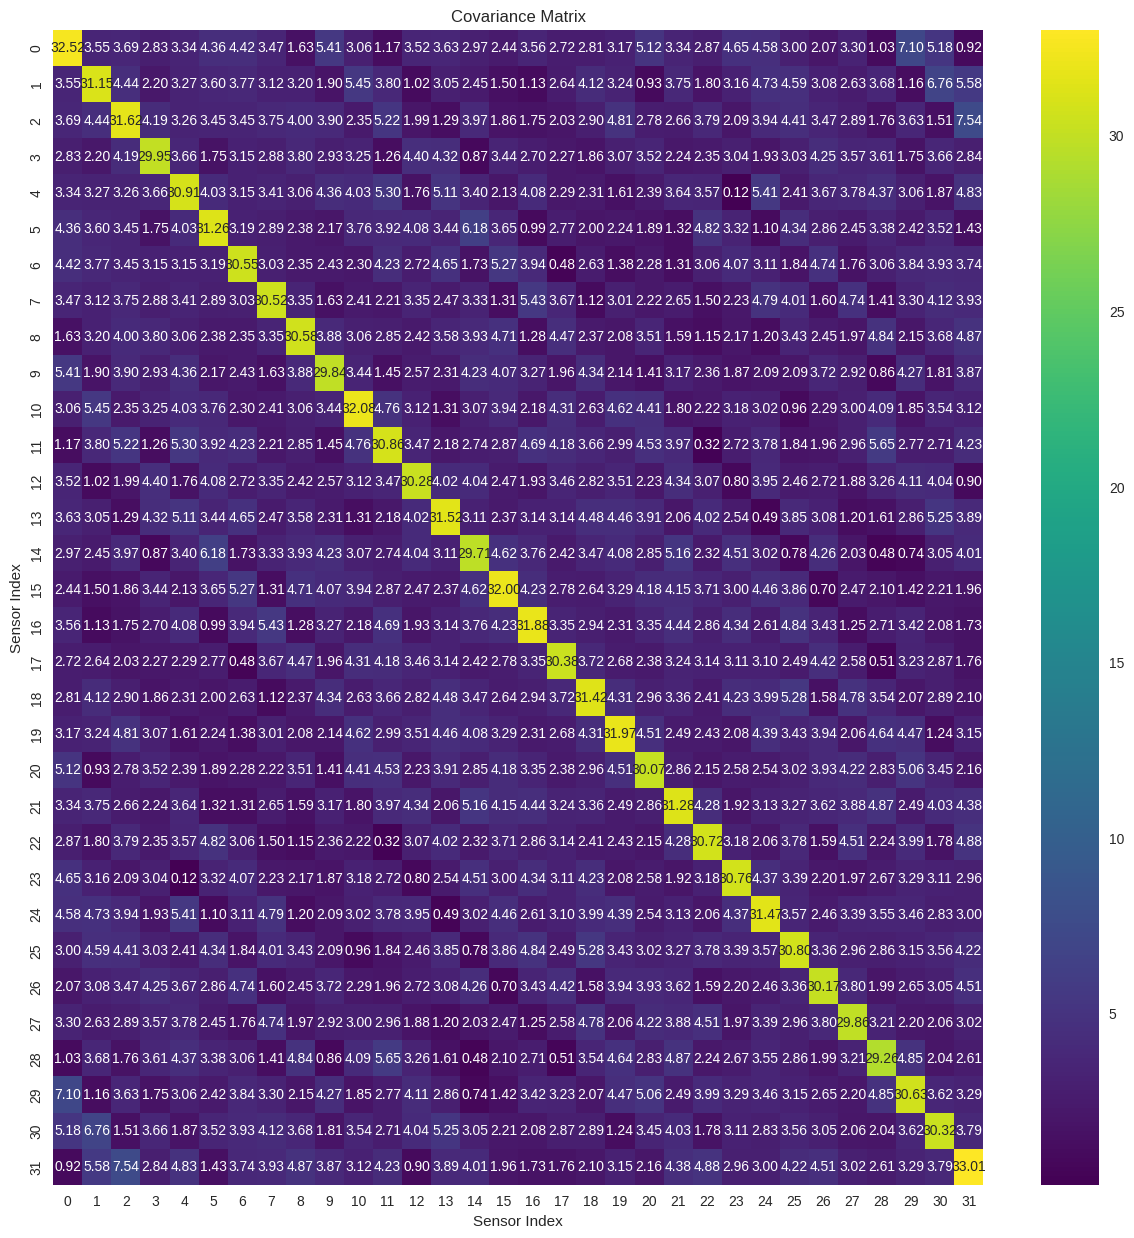

In [418]:
# Plot covariance matrix heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(np.abs(Rxx), annot=True, fmt=".2f", cmap='viridis')
plt.title("Covariance Matrix")
plt.xlabel("Sensor Index")
plt.ylabel("Sensor Index")
plt.show()

## **7. MUSIC DOA Estimation**

The MUSIC spatial spectrum:

$$
P_{\text{MUSIC}}(\theta) = \frac{1}{\mathbf{a}(\theta)^H \mathbf{E}_n \mathbf{E}_n^H \mathbf{a}(\theta)}
$$

Where:
- $\mathbf{a}(\theta)$ — steering vector for angle $\theta$
- $\mathbf{E}_n$ — noise subspace (eigenvectors of smallest eigenvalues of $\mathbf{R}_{xx}$)

In [419]:
# Function for MUSIC DOA Estimation
def music_doa_estimation(X, num_sources, d=0.5, scan_angles=np.arange(-90, 91, 0.1)):
    M, N = X.shape
    Rxx = (X @ X.conj().T) / N
    eigvals, eigvecs = np.linalg.eigh(Rxx)  # eigh for Hermitian
    idx = eigvals.argsort()[::-1]
    eigvecs = eigvecs[:, idx]
    En = eigvecs[:, num_sources:]  # Noise subspace

    P_music = []
    for angle in scan_angles:
        theta = np.deg2rad(angle)
        a = np.exp(-1j * 2 * np.pi * d * np.arange(M) * np.sin(theta)).reshape(-1,1)
        P = 1 / np.abs(a.conj().T @ En @ En.conj().T @ a)
        P_music.append(P[0,0].real)

    return np.array(scan_angles), np.array(P_music)

# Snapshot-Averaged MUSIC Estimation
def snapshot_averaged_music(X, num_sources, N_snapshots=5, scan_angles=np.arange(-90, 91, 0.1)):
    M, total_samples = X.shape
    P_avg = None
    for n in range(N_snapshots):
        start = n*(total_samples//N_snapshots)
        end = (n+1)*(total_samples//N_snapshots)
        X_snap = X[:, start:end]
        _, P_music = music_doa_estimation(X_snap, num_sources, scan_angles=scan_angles)
        if P_avg is None:
            P_avg = P_music
        else:
            P_avg += P_music
    P_avg /= N_snapshots
    return scan_angles, P_avg

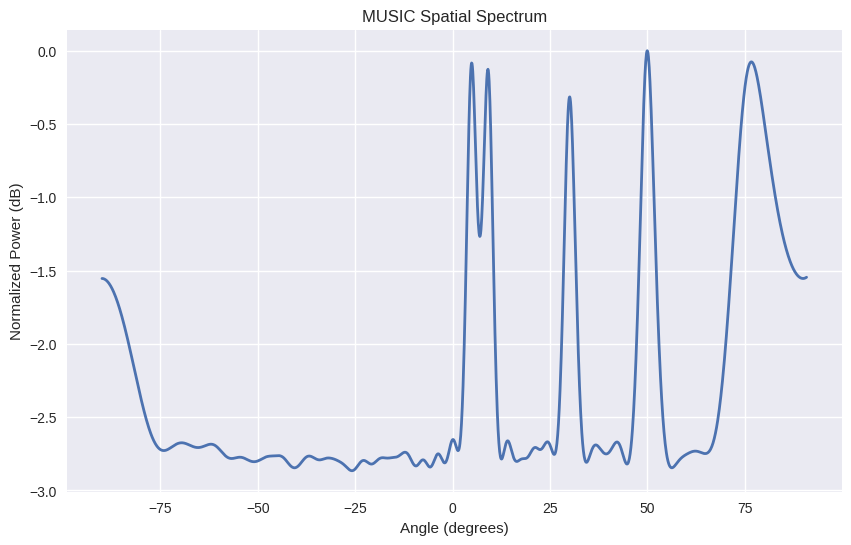

In [420]:
scan_angles, P_music_avg = snapshot_averaged_music(X, num_sources, N_snapshots=50)

# Plot MUSIC Spectrum
plt.figure(figsize=(10,6))
plt.plot(scan_angles, 10*np.log10(P_music_avg/np.max(P_music_avg)), linewidth=2)
plt.title("MUSIC Spatial Spectrum")
plt.xlabel("Angle (degrees)")
plt.ylabel("Normalized Power (dB)")
plt.grid(True)
plt.show()

In [424]:
# Find peaks
peaks, properties = find_peaks(
    P_music_avg,
    height=np.mean(P_music_avg) + 2 * np.std(P_music_avg),  # Adaptive threshold
    prominence=0.2 * np.max(P_music_avg),  # Significant peaks
    distance=20,  # 2° separation
)
estimated_DOAs = scan_angles[peaks]

# Handle missed detections by checking lengths
if len(estimated_DOAs) < len(angles):
    estimated_DOAs = np.append(estimated_DOAs, [0]*(len(angles) - len(estimated_DOAs)))
    print("Warning: Some DOAs were not detected; added zeros for missed detections.")

# Convert to floats and sort
estimated_DOAs_clean = [float(np.round(angle,2)) for angle in estimated_DOAs]
original_DOAs_clean = [float(angle) for angle in angles]

print("Estimated DOAs (degrees):", sorted(estimated_DOAs_clean))
print("Original DOAs (degrees):", sorted(original_DOAs_clean))

Estimated DOAs (degrees): [4.9, 9.1, 30.1, 50.0, 76.7]
Original DOAs (degrees): [5.0, 9.0, 30.0, 50.0, 77.0]


In [425]:
def calculate_rmse_mse(estimated_DOAs_clean, original_DOAs_clean):
    try:
        # Compute RMSE / MSE
        rmse = np.sqrt(np.mean((np.sort(estimated_DOAs_clean) - np.sort(original_DOAs_clean))**2))
        mse = np.mean((np.sort(estimated_DOAs_clean) - np.sort(original_DOAs_clean))**2)
        print(f"RMSE: {rmse:.2f}°, MSE: {mse:.2f}°")
    except ValueError:
        print("Error in RMSE/MSE calculation: Mismatched number of estimated and original DOAs.")

In [426]:
calculate_rmse_mse(estimated_DOAs_clean, original_DOAs_clean)

RMSE: 0.15°, MSE: 0.02°


## **8. Capon (MVDR) DOA Estimation**

Capon (MVDR) spatial spectrum:

$$
P_\text{Capon}(\theta) = \frac{1}{\mathbf{a}(\theta)^H \mathbf{R}_{xx}^{-1} \mathbf{a}(\theta)}
$$
where $\mathbf{R}_{xx}$ is the spatial correlation matrix.

In [427]:
# Function for Capon DOA Estimation
def capon_doa_estimation(X, d=0.5, scan_angles=np.arange(-90,91,0.1)):
    M, N = X.shape
    Rxx = (X @ X.conj().T) / N        # Spatial correlation matrix
    Rxx_inv = np.linalg.pinv(Rxx)     # Pseudo-inverse for stability
    P_capon = []
    for angle in scan_angles:
        theta = np.deg2rad(angle)
        a = np.exp(-1j*2*np.pi*d*np.arange(M)*np.sin(theta)).reshape(-1,1)
        P = 1 / np.real(a.conj().T @ Rxx_inv @ a)
        P_capon.append(P[0,0])
    return np.array(scan_angles), np.array(P_capon)

# Snapshot-Averaged Capon
def snapshot_averaged_capon(X, N_snapshots=5, d=0.5, scan_angles=np.arange(-90,91,0.1)):
    M, total_samples = X.shape
    P_avg = None
    for n in range(N_snapshots):
        start = n*(total_samples//N_snapshots)
        end = (n+1)*(total_samples//N_snapshots)
        X_snap = X[:, start:end]
        _, P = capon_doa_estimation(X_snap, d=d, scan_angles=scan_angles)
        if P_avg is None:
            P_avg = P
        else:
            P_avg += P
    P_avg /= N_snapshots
    return scan_angles, P_avg

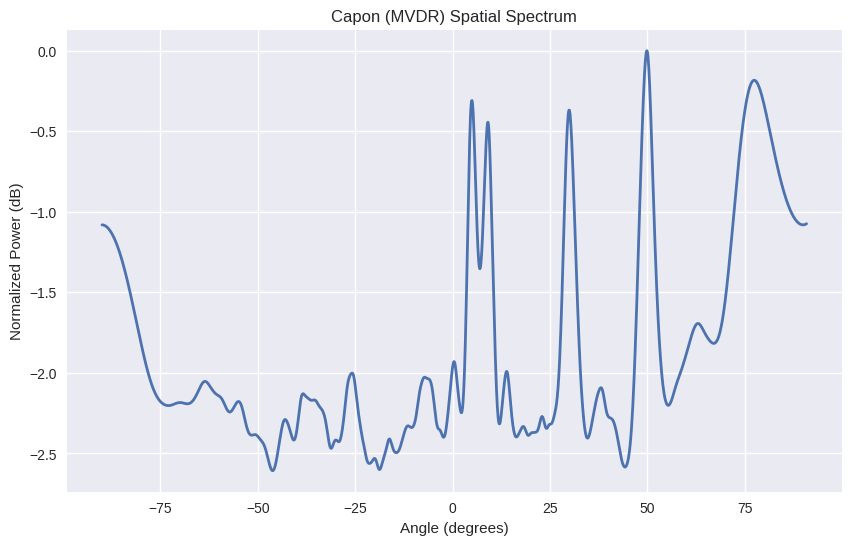

In [428]:
scan_angles, P_capon_avg = snapshot_averaged_capon(X, N_snapshots=50)

# Plot Capon Spectrum
plt.figure(figsize=(10,6))
plt.plot(scan_angles, 10*np.log10(P_capon_avg/np.max(P_capon_avg)), linewidth=2)
plt.title("Capon (MVDR) Spatial Spectrum")
plt.xlabel("Angle (degrees)")
plt.ylabel("Normalized Power (dB)")
plt.grid(True)
plt.show()


In [430]:
# Detect peaks
peaks, properties = find_peaks(
    P_music_avg,
    height=np.mean(P_music_avg) + 2 * np.std(P_music_avg),  # Adaptive threshold
    prominence=0.2 * np.max(P_music_avg),  # Significant peaks
    distance=20,  # 2° separation
)
estimated_DOAs = scan_angles[peaks]

# Handle missed detections by checking lengths
if len(estimated_DOAs) < len(angles):
    estimated_DOAs = np.append(estimated_DOAs, [0]*(len(angles) - len(estimated_DOAs)))
    print("Warning: Some DOAs were not detected; added zeros for missed detections.")

# Sort and convert to floats
estimated_DOAs_clean = [float(np.round(angle,2)) for angle in estimated_DOAs]
original_DOAs_clean = [float(angle) for angle in angles]

print("Estimated DOAs (degrees):", sorted(estimated_DOAs_clean))
print("Original DOAs (degrees):", sorted(original_DOAs_clean))

Estimated DOAs (degrees): [4.9, 9.1, 30.1, 50.0, 76.7]
Original DOAs (degrees): [5.0, 9.0, 30.0, 50.0, 77.0]


In [431]:
# Compute RMSE / MSE
calculate_rmse_mse(estimated_DOAs_clean, original_DOAs_clean)

RMSE: 0.15°, MSE: 0.02°


## **Comparison Between MUSIC and Capon**

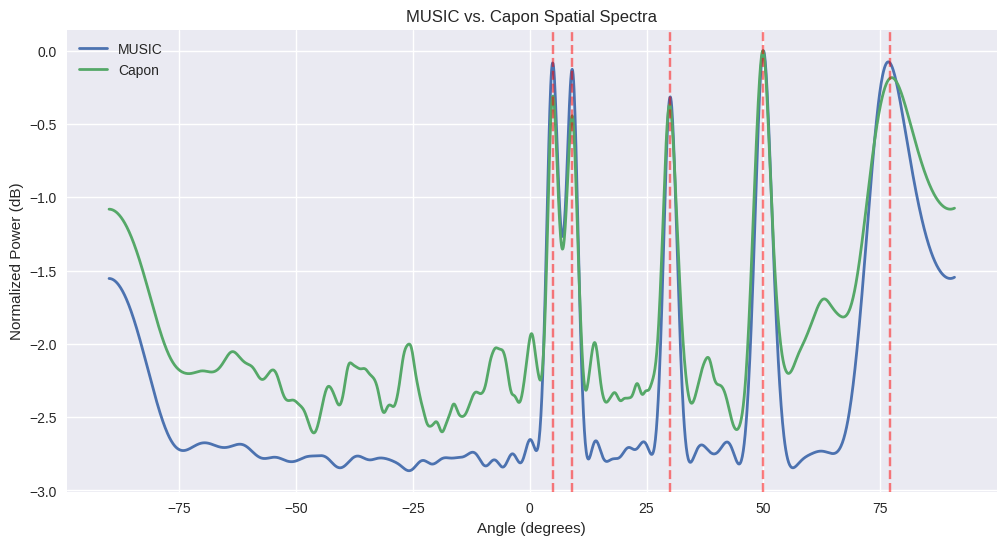

In [432]:
# Plot MUSIC and Capon Spectra Together
plt.figure(figsize=(12, 6))
plt.plot(scan_angles, 10 * np.log10(P_music_avg / np.max(P_music_avg)), label='MUSIC', linewidth=2)
plt.plot(scan_angles, 10 * np.log10(P_capon_avg / np.max(P_capon_avg)), label='Capon', linewidth=2)
for angle in angles:
    plt.axvline(x=angle, color='r', linestyle='--', alpha=0.5)
plt.title("MUSIC vs. Capon Spatial Spectra")
plt.xlabel("Angle (degrees)")
plt.ylabel("Normalized Power (dB)")
plt.legend()
plt.grid(True)
plt.show()